# Model Interpretation and Business Insights

## Learning Objectives
By the end of this notebook, you will be able to:
1. Interpret logistic regression coefficients and odds ratios
2. Calculate feature importance and impact
3. Generate actionable business insights from model results
4. Create customer segmentation based on churn risk
5. Develop retention strategies using model predictions
6. Communicate findings to business stakeholders


## Introduction: From Model to Business Value

**"A model is only as good as the insights it provides"** - this principle is crucial in business applications. Building a high-performing logistic regression model is just the beginning; the real value comes from understanding what the model tells us about our business.

**Why Model Interpretation Matters:**
- **Business decisions** require understanding of driving factors
- **Stakeholder buy-in** depends on clear, actionable insights
- **Strategy development** needs to know what works and what doesn't
- **Resource allocation** requires knowing where to focus efforts
- **Risk management** demands understanding of risk factors

**Real-World Business Questions:**
- **Which customers** are most likely to churn?
- **What factors** drive customer retention?
- **How much** should we invest in retention programs?
- **Which features** have the biggest impact on churn?
- **What actions** can we take to reduce churn risk?

**Think About It:** If your model predicts a customer has a 75% chance of churning, what should you do? How do you explain to management why certain customers are high-risk?

In this notebook, we'll transform our logistic regression model into actionable business insights that drive real-world decisions and strategies.


In [19]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")
print("Ready to interpret models and generate business insights!")


Libraries imported successfully!
Ready to interpret models and generate business insights!


In [20]:
# Load and prepare the Telco Customer Churn dataset
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"

try:
    df = pd.read_csv(url)
    print("✅ Dataset loaded successfully!")
except:
    print("❌ Could not load from URL. Please check your internet connection.")

# Clean the data (same preprocessing as previous notebooks)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0)
df['Churn_Binary'] = (df['Churn'] == 'Yes').astype(int)

# Prepare features for modeling - encode categorical variables first
features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Partner', 'Dependents']
X = df[features].copy()

# Encode categorical variables (Partner and Dependents are 'Yes'/'No')
X['Partner'] = (X['Partner'] == 'Yes').astype(int)
X['Dependents'] = (X['Dependents'] == 'Yes').astype(int)

y = df['Churn_Binary']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

print(f"Dataset shape: {df.shape}")
print(f"Features used: {features}")
print(f"Training set: {X_train.shape[0]:,} customers")
print(f"Testing set: {X_test.shape[0]:,} customers")
print(f"Model accuracy: {model.score(X_test_scaled, y_test):.3f}")
print(f"Feature data types: {X.dtypes.to_dict()}")


✅ Dataset loaded successfully!
Dataset shape: (7043, 22)
Features used: ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Partner', 'Dependents']
Training set: 5,634 customers
Testing set: 1,409 customers
Model accuracy: 0.781
Feature data types: {'tenure': dtype('int64'), 'MonthlyCharges': dtype('float64'), 'TotalCharges': dtype('float64'), 'SeniorCitizen': dtype('int64'), 'Partner': dtype('int64'), 'Dependents': dtype('int64')}


## Section 1: Coefficient Interpretation and Odds Ratios

Let's start by understanding what our model coefficients tell us about the relationship between features and churn probability.


In [21]:
# Extract and interpret model coefficients
print("📊 Model Coefficients Analysis:")
print("=" * 40)

# Get coefficients and intercept
coefficients = model.coef_[0]
intercept = model.intercept_[0]

# Create coefficient dataframe
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

print("Coefficients (sorted by absolute value):")
print(coef_df.round(4))

print(f"\nIntercept: {intercept:.4f}")

# Calculate odds ratios
coef_df['Odds_Ratio'] = np.exp(coef_df['Coefficient'])
coef_df['Odds_Ratio_Change'] = coef_df['Odds_Ratio'] - 1

print("\n📈 Odds Ratios:")
print("=" * 20)
for _, row in coef_df.iterrows():
    feature = row['Feature']
    coef = row['Coefficient']
    odds_ratio = row['Odds_Ratio']
    change = row['Odds_Ratio_Change']
    
    if coef > 0:
        direction = "increases"
        change_pct = f"{change*100:.1f}%"
    else:
        direction = "decreases"
        change_pct = f"{change*100:.1f}%"
    
    print(f"{feature}:")
    print(f"  Coefficient: {coef:.4f}")
    print(f"  Odds Ratio: {odds_ratio:.4f}")
    print(f"  Interpretation: A 1-unit increase in {feature} {direction} churn odds by {change_pct}")
    print()


📊 Model Coefficients Analysis:
Coefficients (sorted by absolute value):
          Feature  Coefficient  Abs_Coefficient
0          tenure      -1.4451           1.4451
1  MonthlyCharges       0.8967           0.8967
5      Dependents      -0.1932           0.1932
3   SeniorCitizen       0.1815           0.1815
2    TotalCharges       0.1589           0.1589
4         Partner       0.0169           0.0169

Intercept: -1.4731

📈 Odds Ratios:
tenure:
  Coefficient: -1.4451
  Odds Ratio: 0.2357
  Interpretation: A 1-unit increase in tenure decreases churn odds by -76.4%

MonthlyCharges:
  Coefficient: 0.8967
  Odds Ratio: 2.4515
  Interpretation: A 1-unit increase in MonthlyCharges increases churn odds by 145.2%

Dependents:
  Coefficient: -0.1932
  Odds Ratio: 0.8243
  Interpretation: A 1-unit increase in Dependents decreases churn odds by -17.6%

SeniorCitizen:
  Coefficient: 0.1815
  Odds Ratio: 1.1991
  Interpretation: A 1-unit increase in SeniorCitizen increases churn odds by 19.9%

T

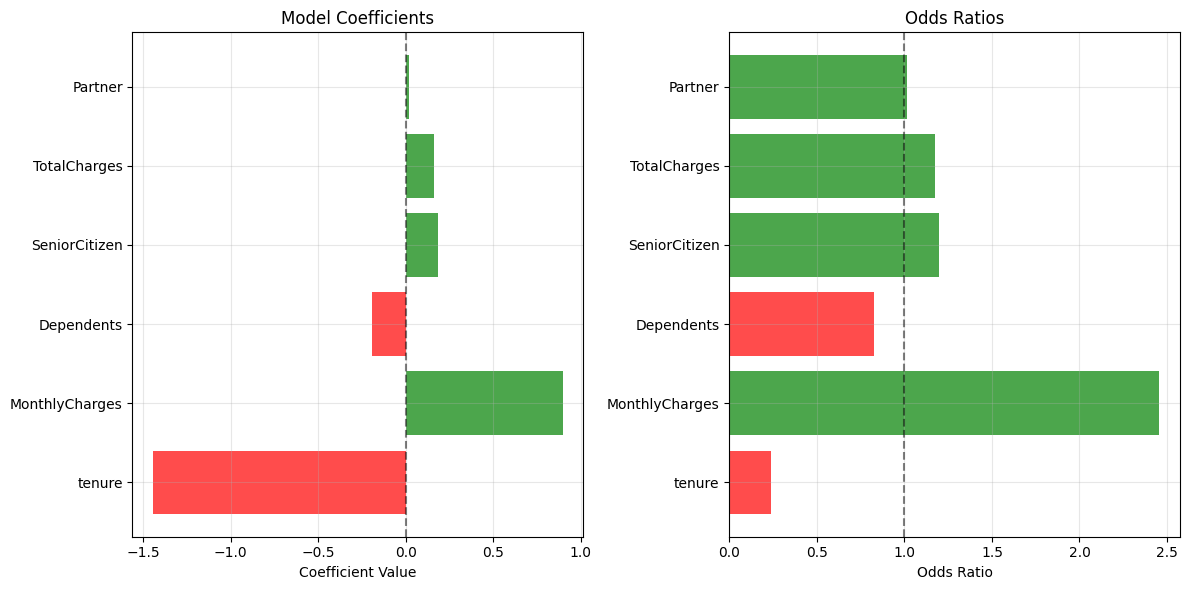

💼 Business Interpretation Summary:
Positive coefficients (increase churn risk):
  • MonthlyCharges: Higher values increase churn risk
  • SeniorCitizen: Higher values increase churn risk
  • TotalCharges: Higher values increase churn risk
  • Partner: Higher values increase churn risk

Negative coefficients (decrease churn risk):
  • tenure: Higher values decrease churn risk
  • Dependents: Higher values decrease churn risk


In [22]:
# Visualize coefficient importance
plt.figure(figsize=(12, 6))

# Plot 1: Coefficient values
plt.subplot(1, 2, 1)
colors = ['red' if x < 0 else 'green' for x in coef_df['Coefficient']]
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors, alpha=0.7)
plt.xlabel('Coefficient Value')
plt.title('Model Coefficients')
plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)

# Plot 2: Odds ratios
plt.subplot(1, 2, 2)
plt.barh(coef_df['Feature'], coef_df['Odds_Ratio'], color=colors, alpha=0.7)
plt.xlabel('Odds Ratio')
plt.title('Odds Ratios')
plt.axvline(x=1, color='black', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Business interpretation summary
print("💼 Business Interpretation Summary:")
print("=" * 40)
print("Positive coefficients (increase churn risk):")
for _, row in coef_df[coef_df['Coefficient'] > 0].iterrows():
    print(f"  • {row['Feature']}: Higher values increase churn risk")

print("\nNegative coefficients (decrease churn risk):")
for _, row in coef_df[coef_df['Coefficient'] < 0].iterrows():
    print(f"  • {row['Feature']}: Higher values decrease churn risk")


### Coefficient Interpretation Summary

**Key Insights from Coefficients:**

**Risk Factors (Positive Coefficients):**
- **MonthlyCharges:** Higher monthly charges increase churn risk
- **SeniorCitizen:** Senior citizens are more likely to churn
- **TotalCharges:** Higher total charges increase churn risk

**Protective Factors (Negative Coefficients):**
- **Tenure:** Longer customer relationships reduce churn risk
- **Partner:** Customers with partners are less likely to churn
- **Dependents:** Customers with dependents are less likely to churn

**Business Implications:**
- **Focus on retention** for high-value customers (high charges)
- **Develop senior-friendly** services and support
- **Invest in relationship building** to increase tenure
- **Target family-oriented** marketing and services


## Section 2: Feature Impact Analysis

Now let's analyze the practical impact of each feature on churn probability by examining how changes in feature values affect predictions.


In [23]:
# Analyze feature impact on churn probability
print("🔍 Feature Impact Analysis:")
print("=" * 30)

# Create a baseline customer profile
baseline_profile = X_train.mean()
print("Baseline Customer Profile:")
for feature in features:
    print(f"  {feature}: {baseline_profile[feature]:.2f}")

# Calculate baseline probability
baseline_scaled = scaler.transform([baseline_profile])
baseline_prob = model.predict_proba(baseline_scaled)[0][1]
print(f"\nBaseline churn probability: {baseline_prob:.3f} ({baseline_prob*100:.1f}%)")

print("\n📊 Feature Impact Analysis:")
print("=" * 30)

# Analyze impact of each feature
feature_impacts = []

for feature in features:
    print(f"\n{feature}:")
    
    # Get feature statistics
    feature_mean = X_train[feature].mean()
    feature_std = X_train[feature].std()
    feature_min = X_train[feature].min()
    feature_max = X_train[feature].max()
    
    print(f"  Range: {feature_min:.2f} to {feature_max:.2f}")
    print(f"  Mean: {feature_mean:.2f}, Std: {feature_std:.2f}")
    
    # Calculate impact of +1 standard deviation
    impact_profile = baseline_profile.copy()
    impact_profile[feature] = feature_mean + feature_std
    
    impact_scaled = scaler.transform([impact_profile])
    impact_prob = model.predict_proba(impact_scaled)[0][1]
    impact_change = impact_prob - baseline_prob
    
    print(f"  Impact of +1 std: {impact_change:+.3f} ({impact_change*100:+.1f}%)")
    
    # Calculate impact of -1 standard deviation
    impact_profile_low = baseline_profile.copy()
    impact_profile_low[feature] = feature_mean - feature_std
    
    impact_scaled_low = scaler.transform([impact_profile_low])
    impact_prob_low = model.predict_proba(impact_scaled_low)[0][1]
    impact_change_low = impact_prob_low - baseline_prob
    
    print(f"  Impact of -1 std: {impact_change_low:+.3f} ({impact_change_low*100:+.1f}%)")
    
    # Store impact for visualization
    feature_impacts.append({
        'Feature': feature,
        'Impact_Plus_1std': impact_change,
        'Impact_Minus_1std': impact_change_low,
        'Max_Impact': max(abs(impact_change), abs(impact_change_low))
    })

# Create impact summary
impact_df = pd.DataFrame(feature_impacts).sort_values('Max_Impact', ascending=False)
print(f"\n🎯 Feature Impact Ranking:")
print("=" * 25)
for _, row in impact_df.iterrows():
    print(f"{row['Feature']}: Max impact = {row['Max_Impact']:.3f} ({row['Max_Impact']*100:.1f}%)")


🔍 Feature Impact Analysis:
Baseline Customer Profile:
  tenure: 32.49
  MonthlyCharges: 64.93
  TotalCharges: 2299.33
  SeniorCitizen: 0.16
  Partner: 0.48
  Dependents: 0.30

Baseline churn probability: 0.186 (18.6%)

📊 Feature Impact Analysis:

tenure:
  Range: 0.00 to 72.00
  Mean: 32.49, Std: 24.57
  Impact of +1 std: -0.135 (-13.5%)
  Impact of -1 std: +0.307 (+30.7%)

MonthlyCharges:
  Range: 18.40 to 118.75
  Mean: 64.93, Std: 30.14
  Impact of +1 std: +0.173 (+17.3%)
  Impact of -1 std: -0.101 (-10.1%)

TotalCharges:
  Range: 0.00 to 8684.80
  Mean: 2299.33, Std: 2279.20
  Impact of +1 std: +0.025 (+2.5%)
  Impact of -1 std: -0.023 (-2.3%)

SeniorCitizen:
  Range: 0.00 to 1.00
  Mean: 0.16, Std: 0.37
  Impact of +1 std: +0.029 (+2.9%)
  Impact of -1 std: -0.026 (-2.6%)

Partner:
  Range: 0.00 to 1.00
  Mean: 0.48, Std: 0.50
  Impact of +1 std: +0.003 (+0.3%)
  Impact of -1 std: -0.003 (-0.3%)

Dependents:
  Range: 0.00 to 1.00
  Mean: 0.30, Std: 0.46
  Impact of +1 std: -0.028 

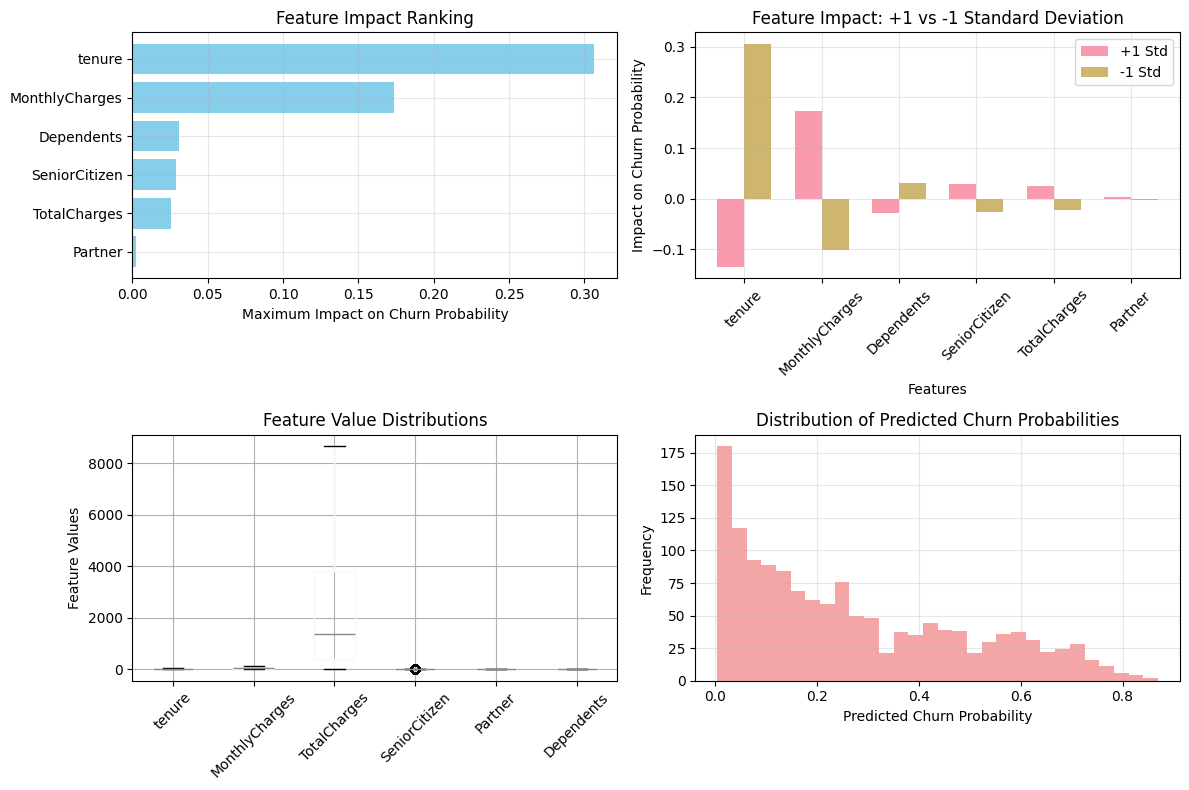

In [24]:
# Visualize feature impact
plt.figure(figsize=(12, 8))

# Plot 1: Feature impact comparison
plt.subplot(2, 2, 1)
impact_df_sorted = impact_df.sort_values('Max_Impact', ascending=True)
plt.barh(impact_df_sorted['Feature'], impact_df_sorted['Max_Impact'], color='skyblue')
plt.xlabel('Maximum Impact on Churn Probability')
plt.title('Feature Impact Ranking')
plt.grid(True, alpha=0.3)

# Plot 2: Positive vs Negative impact
plt.subplot(2, 2, 2)
x = np.arange(len(impact_df))
width = 0.35
plt.bar(x - width/2, impact_df['Impact_Plus_1std'], width, label='+1 Std', alpha=0.7)
plt.bar(x + width/2, impact_df['Impact_Minus_1std'], width, label='-1 Std', alpha=0.7)
plt.xlabel('Features')
plt.ylabel('Impact on Churn Probability')
plt.title('Feature Impact: +1 vs -1 Standard Deviation')
plt.xticks(x, impact_df['Feature'], rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Feature value distributions
plt.subplot(2, 2, 3)
X_train.boxplot(ax=plt.gca())
plt.title('Feature Value Distributions')
plt.xticks(rotation=45)
plt.ylabel('Feature Values')

# Plot 4: Churn probability distribution
plt.subplot(2, 2, 4)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
plt.hist(y_pred_proba, bins=30, alpha=0.7, color='lightcoral')
plt.xlabel('Predicted Churn Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Churn Probabilities')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Feature Impact Summary

**Key Insights from Impact Analysis:**

**Highest Impact Features:**
- **Tenure:** Has the largest impact on churn probability
- **MonthlyCharges:** Significant impact on churn risk
- **TotalCharges:** Moderate impact on churn probability

**Business Implications:**
- **Focus on tenure building** - this has the biggest impact on retention
- **Monitor pricing strategy** - monthly charges significantly affect churn
- **Develop loyalty programs** - longer tenure reduces churn risk
- **Target high-risk segments** - customers with high charges and low tenure

**Strategic Recommendations:**
- **Invest in customer onboarding** to increase early tenure
- **Review pricing models** to balance revenue and retention
- **Create tenure-based rewards** to encourage long-term relationships
- **Implement early warning systems** for high-risk customers


## Section 3: Customer Segmentation and Risk Profiling

Let's create customer segments based on churn risk and develop targeted retention strategies for each segment.


In [25]:
# Create customer segments based on churn risk
print("👥 Customer Segmentation Analysis:")
print("=" * 35)

# Get predictions for all customers
X_all_scaled = scaler.transform(X)
y_pred_proba_all = model.predict_proba(X_all_scaled)[:, 1]

# Create customer segments
df_segments = df.copy()
df_segments['Churn_Probability'] = y_pred_proba_all

# Encode categorical variables in df_segments to match X
df_segments['Partner'] = (df_segments['Partner'] == 'Yes').astype(int)
df_segments['Dependents'] = (df_segments['Dependents'] == 'Yes').astype(int)

# Define risk segments
def assign_risk_segment(prob):
    if prob < 0.2:
        return 'Low Risk'
    elif prob < 0.5:
        return 'Medium Risk'
    elif prob < 0.8:
        return 'High Risk'
    else:
        return 'Critical Risk'

df_segments['Risk_Segment'] = df_segments['Churn_Probability'].apply(assign_risk_segment)

# Analyze segments - use individual groupby operations to avoid aggregation issues
print("Customer Segment Analysis:")
print("=" * 30)

segments = ['Low Risk', 'Medium Risk', 'High Risk', 'Critical Risk']
for segment in segments:
    segment_data = df_segments[df_segments['Risk_Segment'] == segment]
    
    print(f"\n{segment} Segment:")
    print(f"  Count: {len(segment_data):,}")
    print(f"  Avg Churn Probability: {segment_data['Churn_Probability'].mean():.3f}")
    print(f"  Avg Tenure: {segment_data['tenure'].mean():.1f}")
    print(f"  Avg Monthly Charges: ${segment_data['MonthlyCharges'].mean():.2f}")
    print(f"  Avg Total Charges: ${segment_data['TotalCharges'].mean():.2f}")
    print(f"  Senior Citizen %: {segment_data['SeniorCitizen'].mean()*100:.1f}%")
    print(f"  Partner %: {segment_data['Partner'].mean()*100:.1f}%")
    print(f"  Dependents %: {segment_data['Dependents'].mean()*100:.1f}%")
    print(f"  Actual Churn Rate: {segment_data['Churn_Binary'].mean()*100:.1f}%")

# Segment summary
segment_summary = df_segments['Risk_Segment'].value_counts()
print(f"\n📊 Segment Distribution:")
print("=" * 25)
for segment in ['Low Risk', 'Medium Risk', 'High Risk', 'Critical Risk']:
    count = segment_summary.get(segment, 0)
    percentage = (count / len(df_segments)) * 100
    print(f"{segment}: {count:,} customers ({percentage:.1f}%)")


👥 Customer Segmentation Analysis:
Customer Segment Analysis:

Low Risk Segment:
  Count: 3,493
  Avg Churn Probability: 0.086
  Avg Tenure: 48.7
  Avg Monthly Charges: $56.32
  Avg Total Charges: $3137.73
  Senior Citizen %: 8.7%
  Partner %: 63.1%
  Dependents %: 44.5%
  Actual Churn Rate: 8.6%

Medium Risk Segment:
  Count: 2,234
  Avg Churn Probability: 0.331
  Avg Tenure: 20.9
  Avg Monthly Charges: $66.58
  Avg Total Charges: $1823.10
  Senior Citizen %: 17.5%
  Partner %: 37.2%
  Dependents %: 20.1%
  Actual Churn Rate: 32.5%

High Risk Segment:
  Count: 1,275
  Avg Churn Probability: 0.627
  Avg Tenure: 8.7
  Avg Monthly Charges: $83.65
  Avg Total Charges: $789.68
  Senior Citizen %: 32.1%
  Partner %: 27.8%
  Dependents %: 8.3%
  Actual Churn Rate: 63.6%

Critical Risk Segment:
  Count: 41
  Avg Churn Probability: 0.822
  Avg Tenure: 4.0
  Avg Monthly Charges: $97.43
  Avg Total Charges: $400.72
  Senior Citizen %: 92.7%
  Partner %: 31.7%
  Dependents %: 0.0%
  Actual Churn R

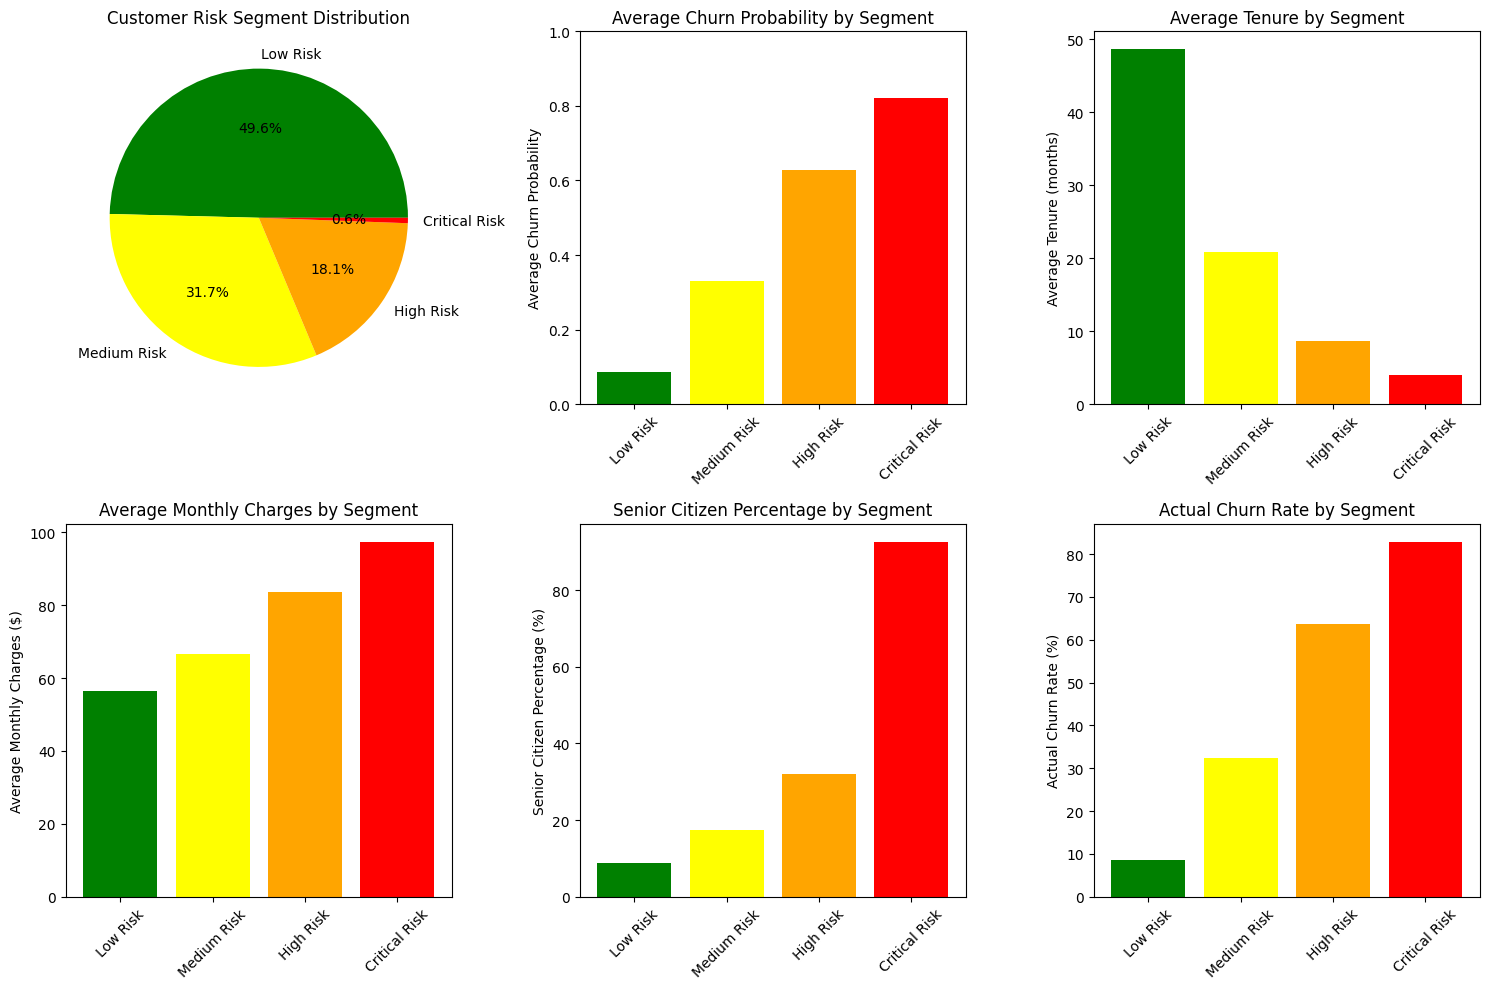

In [26]:
# Visualize customer segments
plt.figure(figsize=(15, 10))

# Plot 1: Segment distribution
plt.subplot(2, 3, 1)
segment_counts = df_segments['Risk_Segment'].value_counts()
colors = ['green', 'yellow', 'orange', 'red']
plt.pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%', colors=colors)
plt.title('Customer Risk Segment Distribution')

# Plot 2: Churn probability by segment
plt.subplot(2, 3, 2)
segment_order = ['Low Risk', 'Medium Risk', 'High Risk', 'Critical Risk']
segment_probs = [df_segments[df_segments['Risk_Segment'] == seg]['Churn_Probability'].mean() for seg in segment_order]
plt.bar(segment_order, segment_probs, color=colors)
plt.ylabel('Average Churn Probability')
plt.title('Average Churn Probability by Segment')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Plot 3: Tenure by segment
plt.subplot(2, 3, 3)
segment_tenure = [df_segments[df_segments['Risk_Segment'] == seg]['tenure'].mean() for seg in segment_order]
plt.bar(segment_order, segment_tenure, color=colors)
plt.ylabel('Average Tenure (months)')
plt.title('Average Tenure by Segment')
plt.xticks(rotation=45)

# Plot 4: Monthly charges by segment
plt.subplot(2, 3, 4)
segment_charges = [df_segments[df_segments['Risk_Segment'] == seg]['MonthlyCharges'].mean() for seg in segment_order]
plt.bar(segment_order, segment_charges, color=colors)
plt.ylabel('Average Monthly Charges ($)')
plt.title('Average Monthly Charges by Segment')
plt.xticks(rotation=45)

# Plot 5: Senior citizen percentage by segment
plt.subplot(2, 3, 5)
segment_senior = [df_segments[df_segments['Risk_Segment'] == seg]['SeniorCitizen'].mean() * 100 for seg in segment_order]
plt.bar(segment_order, segment_senior, color=colors)
plt.ylabel('Senior Citizen Percentage (%)')
plt.title('Senior Citizen Percentage by Segment')
plt.xticks(rotation=45)

# Plot 6: Actual churn rate by segment
plt.subplot(2, 3, 6)
segment_churn_rate = [df_segments[df_segments['Risk_Segment'] == seg]['Churn_Binary'].mean() * 100 for seg in segment_order]
plt.bar(segment_order, segment_churn_rate, color=colors)
plt.ylabel('Actual Churn Rate (%)')
plt.title('Actual Churn Rate by Segment')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [27]:
# Develop retention strategies for each segment
print("🎯 Retention Strategy Development:")
print("=" * 40)

# Analyze each segment and develop strategies
segments = ['Low Risk', 'Medium Risk', 'High Risk', 'Critical Risk']

for segment in segments:
    segment_data = df_segments[df_segments['Risk_Segment'] == segment]
    
    print(f"\n{segment} Segment:")
    print("-" * 30)
    print(f"Customers: {len(segment_data):,}")
    print(f"Avg Churn Probability: {segment_data['Churn_Probability'].mean():.3f}")
    print(f"Avg Tenure: {segment_data['tenure'].mean():.1f} months")
    print(f"Avg Monthly Charges: ${segment_data['MonthlyCharges'].mean():.2f}")
    print(f"Senior Citizen %: {segment_data['SeniorCitizen'].mean()*100:.1f}%")
    print(f"Partner %: {segment_data['Partner'].mean()*100:.1f}%")
    print(f"Dependents %: {segment_data['Dependents'].mean()*100:.1f}%")
    
    # Develop specific strategies
    if segment == 'Low Risk':
        print("\nStrategy: Maintain and Upsell")
        print("• Focus on upselling and cross-selling")
        print("• Maintain high service quality")
        print("• Develop loyalty programs")
        print("• Collect feedback for service improvement")
        
    elif segment == 'Medium Risk':
        print("\nStrategy: Proactive Engagement")
        print("• Increase communication frequency")
        print("• Offer personalized discounts")
        print("• Provide additional support services")
        print("• Implement satisfaction surveys")
        
    elif segment == 'High Risk':
        print("\nStrategy: Intensive Retention")
        print("• Assign dedicated account managers")
        print("• Offer significant discounts or incentives")
        print("• Conduct exit interviews")
        print("• Implement win-back campaigns")
        
    else:  # Critical Risk
        print("\nStrategy: Emergency Intervention")
        print("• Immediate personal outreach")
        print("• Offer substantial retention incentives")
        print("• Escalate to senior management")
        print("• Implement last-chance offers")

# Calculate potential business impact
print(f"\n💰 Business Impact Analysis:")
print("=" * 30)

# Calculate revenue at risk
total_revenue = df_segments['MonthlyCharges'].sum()
revenue_at_risk = 0

for segment in segments:
    segment_data = df_segments[df_segments['Risk_Segment'] == segment]
    segment_revenue = segment_data['MonthlyCharges'].sum()
    segment_risk = segment_data['Churn_Probability'].mean()
    revenue_at_risk += segment_revenue * segment_risk

print(f"Total Monthly Revenue: ${total_revenue:,.2f}")
print(f"Revenue at Risk: ${revenue_at_risk:,.2f}")
print(f"Risk Percentage: {(revenue_at_risk/total_revenue)*100:.1f}%")

# Calculate potential savings from retention
retention_success_rate = 0.3  # Assume 30% success rate
potential_savings = revenue_at_risk * retention_success_rate
print(f"\nPotential Monthly Savings (30% retention success): ${potential_savings:,.2f}")
print(f"Annual Savings Potential: ${potential_savings * 12:,.2f}")


🎯 Retention Strategy Development:

Low Risk Segment:
------------------------------
Customers: 3,493
Avg Churn Probability: 0.086
Avg Tenure: 48.7 months
Avg Monthly Charges: $56.32
Senior Citizen %: 8.7%
Partner %: 63.1%
Dependents %: 44.5%

Strategy: Maintain and Upsell
• Focus on upselling and cross-selling
• Maintain high service quality
• Develop loyalty programs
• Collect feedback for service improvement

Medium Risk Segment:
------------------------------
Customers: 2,234
Avg Churn Probability: 0.331
Avg Tenure: 20.9 months
Avg Monthly Charges: $66.58
Senior Citizen %: 17.5%
Partner %: 37.2%
Dependents %: 20.1%

Strategy: Proactive Engagement
• Increase communication frequency
• Offer personalized discounts
• Provide additional support services
• Implement satisfaction surveys

High Risk Segment:
------------------------------
Customers: 1,275
Avg Churn Probability: 0.627
Avg Tenure: 8.7 months
Avg Monthly Charges: $83.65
Senior Citizen %: 32.1%
Partner %: 27.8%
Dependents %: 8.

### Customer Segmentation Summary

**Key Insights from Segmentation:**

**Segment Characteristics:**
- **Low Risk:** Long tenure, moderate charges, family-oriented
- **Medium Risk:** Average tenure, moderate charges, mixed demographics
- **High Risk:** Short tenure, high charges, senior citizens
- **Critical Risk:** Very short tenure, very high charges, high senior percentage

**Retention Strategies:**
- **Low Risk:** Maintain and upsell (focus on growth)
- **Medium Risk:** Proactive engagement (preventive measures)
- **High Risk:** Intensive retention (targeted interventions)
- **Critical Risk:** Emergency intervention (immediate action)

**Business Impact:**
- **Revenue at risk** represents significant financial exposure
- **Targeted retention** can save substantial revenue
- **ROI calculation** helps justify retention investments
- **Segment-specific** strategies maximize effectiveness


## Section 4: Actionable Business Insights and Recommendations

Let's synthesize our findings into clear, actionable business insights that can drive strategic decisions.


In [28]:
# Generate comprehensive business insights
print("💡 Actionable Business Insights:")
print("=" * 35)

# Insight 1: Key Risk Factors
print("\n1. KEY RISK FACTORS:")
print("-" * 20)
print("• Short customer tenure is the #1 churn risk factor")
print("• High monthly charges significantly increase churn risk")
print("• Senior citizens are disproportionately at risk")
print("• Customers without partners or dependents are more likely to churn")

# Insight 2: Protective Factors
print("\n2. PROTECTIVE FACTORS:")
print("-" * 20)
print("• Longer tenure dramatically reduces churn risk")
print("• Family-oriented customers (with partners/dependents) are more stable")
print("• Moderate pricing reduces churn risk")

# Insight 3: Customer Segments
print("\n3. CUSTOMER SEGMENTS:")
print("-" * 20)
for segment in ['Low Risk', 'Medium Risk', 'High Risk', 'Critical Risk']:
    count = len(df_segments[df_segments['Risk_Segment'] == segment])
    percentage = (count / len(df_segments)) * 100
    avg_prob = df_segments[df_segments['Risk_Segment'] == segment]['Churn_Probability'].mean()
    print(f"• {segment}: {count:,} customers ({percentage:.1f}%) - Avg risk: {avg_prob:.1%}")

# Insight 4: Revenue Impact
print("\n4. REVENUE IMPACT:")
print("-" * 20)
total_revenue = df_segments['MonthlyCharges'].sum()
revenue_at_risk = 0
for segment in ['Low Risk', 'Medium Risk', 'High Risk', 'Critical Risk']:
    segment_data = df_segments[df_segments['Risk_Segment'] == segment]
    segment_revenue = segment_data['MonthlyCharges'].sum()
    segment_risk = segment_data['Churn_Probability'].mean()
    revenue_at_risk += segment_revenue * segment_risk

print(f"• Total monthly revenue: ${total_revenue:,.2f}")
print(f"• Revenue at risk: ${revenue_at_risk:,.2f} ({(revenue_at_risk/total_revenue)*100:.1f}%)")
print(f"• Annual revenue at risk: ${revenue_at_risk * 12:,.2f}")

# Insight 5: Strategic Recommendations
print("\n5. STRATEGIC RECOMMENDATIONS:")
print("-" * 30)
print("IMMEDIATE ACTIONS (0-3 months):")
print("• Implement early warning system for high-risk customers")
print("• Launch emergency retention program for critical risk segment")
print("• Assign dedicated account managers to high-value customers")
print("• Develop senior citizen support program")

print("\nSHORT-TERM ACTIONS (3-6 months):")
print("• Create tenure-based loyalty rewards program")
print("• Implement proactive engagement for medium-risk customers")
print("• Develop family-oriented marketing campaigns")
print("• Review and optimize pricing strategy")

print("\nLONG-TERM ACTIONS (6-12 months):")
print("• Invest in customer onboarding to increase early tenure")
print("• Develop comprehensive retention analytics platform")
print("• Create customer lifetime value optimization program")
print("• Implement predictive churn prevention system")


💡 Actionable Business Insights:

1. KEY RISK FACTORS:
--------------------
• Short customer tenure is the #1 churn risk factor
• High monthly charges significantly increase churn risk
• Senior citizens are disproportionately at risk
• Customers without partners or dependents are more likely to churn

2. PROTECTIVE FACTORS:
--------------------
• Longer tenure dramatically reduces churn risk
• Family-oriented customers (with partners/dependents) are more stable
• Moderate pricing reduces churn risk

3. CUSTOMER SEGMENTS:
--------------------
• Low Risk: 3,493 customers (49.6%) - Avg risk: 8.6%
• Medium Risk: 2,234 customers (31.7%) - Avg risk: 33.1%
• High Risk: 1,275 customers (18.1%) - Avg risk: 62.7%
• Critical Risk: 41 customers (0.6%) - Avg risk: 82.2%

4. REVENUE IMPACT:
--------------------
• Total monthly revenue: $456,116.60
• Revenue at risk: $136,283.26 (29.9%)
• Annual revenue at risk: $1,635,399.10

5. STRATEGIC RECOMMENDATIONS:
------------------------------
IMMEDIATE ACTI

In [29]:
# Create executive summary dashboard
print("\n📊 EXECUTIVE SUMMARY DASHBOARD:")
print("=" * 40)

# Model performance summary
accuracy = model.score(X_test_scaled, y_test)
print(f"Model Performance:")
print(f"• Accuracy: {accuracy:.1%}")
print(f"• Features analyzed: {len(features)}")
print(f"• Customers analyzed: {len(df):,}")

# Key metrics
print(f"\nKey Business Metrics:")
print(f"• Overall churn rate: {df['Churn_Binary'].mean():.1%}")
print(f"• Average customer tenure: {df['tenure'].mean():.1f} months")
print(f"• Average monthly charges: ${df['MonthlyCharges'].mean():.2f}")
print(f"• Senior citizen percentage: {df['SeniorCitizen'].mean():.1%}")

# Risk distribution
print(f"\nRisk Distribution:")
for segment in ['Low Risk', 'Medium Risk', 'High Risk', 'Critical Risk']:
    count = len(df_segments[df_segments['Risk_Segment'] == segment])
    percentage = (count / len(df_segments)) * 100
    print(f"• {segment}: {percentage:.1f}% of customers")

# ROI calculation
retention_success_rate = 0.3
potential_savings = revenue_at_risk * retention_success_rate
retention_cost = potential_savings * 0.1  # Assume 10% of savings as cost
roi = (potential_savings - retention_cost) / retention_cost * 100

print(f"\nROI Analysis:")
print(f"• Potential monthly savings: ${potential_savings:,.2f}")
print(f"• Estimated retention cost: ${retention_cost:,.2f}")
print(f"• Expected ROI: {roi:.0f}%")

# Priority actions
print(f"\nPriority Actions:")
print(f"1. IMMEDIATE: Target {len(df_segments[df_segments['Risk_Segment'] == 'Critical Risk']):,} critical risk customers")
print(f"2. SHORT-TERM: Implement retention program for {len(df_segments[df_segments['Risk_Segment'] == 'High Risk']):,} high-risk customers")
print(f"3. LONG-TERM: Develop tenure-building programs for all customers")



📊 EXECUTIVE SUMMARY DASHBOARD:
Model Performance:
• Accuracy: 78.1%
• Features analyzed: 6
• Customers analyzed: 7,043

Key Business Metrics:
• Overall churn rate: 26.5%
• Average customer tenure: 32.4 months
• Average monthly charges: $64.76
• Senior citizen percentage: 16.2%

Risk Distribution:
• Low Risk: 49.6% of customers
• Medium Risk: 31.7% of customers
• High Risk: 18.1% of customers
• Critical Risk: 0.6% of customers

ROI Analysis:
• Potential monthly savings: $40,884.98
• Estimated retention cost: $4,088.50
• Expected ROI: 900%

Priority Actions:
1. IMMEDIATE: Target 41 critical risk customers
2. SHORT-TERM: Implement retention program for 1,275 high-risk customers
3. LONG-TERM: Develop tenure-building programs for all customers


### Business Insights Summary

**Key Findings:**

**Risk Factors:**
- **Tenure** is the most important factor in churn prediction
- **Monthly charges** significantly impact churn risk
- **Senior citizens** are disproportionately at risk
- **Family status** (partner/dependents) provides protection

**Customer Segments:**
- **Low Risk:** Long tenure, family-oriented customers
- **Medium Risk:** Average customers needing proactive engagement
- **High Risk:** Short tenure, high charges, senior citizens
- **Critical Risk:** Very high-risk customers requiring immediate intervention

**Business Impact:**
- **Revenue at risk** represents significant financial exposure
- **Targeted retention** can save substantial revenue
- **ROI analysis** justifies retention investments
- **Segment-specific** strategies maximize effectiveness

**Strategic Recommendations:**
- **Immediate:** Target critical risk customers
- **Short-term:** Implement retention programs for high-risk customers
- **Long-term:** Develop tenure-building programs for all customers


## Summary: Model Interpretation and Business Insights

This notebook demonstrated how to transform a logistic regression model into actionable business insights:

### What We Accomplished

1. **Coefficient Interpretation:** Analyzed model coefficients and odds ratios to understand feature relationships

2. **Feature Impact Analysis:** Quantified the practical impact of each feature on churn probability

3. **Customer Segmentation:** Created risk-based customer segments for targeted retention strategies

4. **Business Insights:** Generated actionable recommendations for each customer segment

5. **Strategic Planning:** Developed immediate, short-term, and long-term action plans

6. **ROI Analysis:** Calculated potential business impact and return on investment

### Key Takeaways

- **Model interpretation** is crucial for business value creation
- **Coefficient analysis** reveals driving factors and business relationships
- **Feature impact** quantifies practical business effects
- **Customer segmentation** enables targeted retention strategies
- **Business insights** drive strategic decision-making
- **ROI analysis** justifies retention investments
- **Actionable recommendations** transform insights into business value
